## Course Dataset

In [1]:
import pandas as pd
import numpy as np
import time
import json
from pandas import json_normalize
from collections import Counter
from top2vec import Top2Vec
import re

2022-05-14 01:02:50.058001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 01:02:50.058050: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def remove_html_tags(text):
    """Remove html tags and new line from a string"""
    clean = re.compile('<.*?>|\n')
    return re.sub(clean, ' ', text)

def normalize(xs):
    return [" ".join(x.lower().split()) for x in xs]


def remove_special_cha(text):
    """Remove special characters from a string"""
    clean = re.compile('[|^&+\-%*/=>():"#$“”]')
    return re.sub(clean, ' ', text)


def list_to_str(text, col):
    y = []
    for elem in text[col]:
        y.append(", ".join(elem))
    return y

def language_preprocess(text):
    text = re.sub("English", "en", text)
    text = re.sub("German", "de", text)
    return text

In [3]:
with open("../data/COURSE/go1contents_2604_reg.json", "r") as f:
    courses = json.load(f)

for c in courses:
    c["tags"] = normalize(c["tags"])
    c["topics"] = normalize([y["value"] for y in c.get("attributes", {}).get("topics", [])])
    c["title"] = remove_special_cha(c["title"])
    c["description"] = remove_special_cha(remove_html_tags(c["description"]))
    c['language'] = language_preprocess(c['language'])
    c["topics_list"] = normalize([y["value"] for y in c.get("attributes", {}).get("topics", [])])

In [4]:
pd.set_option("display.max_column", None)
df = json_normalize(courses) 

df['topics'] = list_to_str(df, 'topics')
df['tags'] = list_to_str(df, 'tags')

df['course_data'] = df[['title', 'topics', 'tags', 'description']].agg(' '.join, axis=1)

## Skill Dataset

In [5]:
esco_skill = pd.read_csv("../data/ESCO/skills_en.csv")
esco_skill = esco_skill.fillna('')

In [6]:
esco_skill['skill_data'] = esco_skill[['preferredLabel', 'altLabels', 'description']].agg(' '.join, axis=1)

## Top2Vec Modelling

### Different Embedding Models
- 1) doc2vec
- 2) distiluse-base-multilingual-cased
- 3) universal-sentence-encoder
- 4) all-MiniLM-L6-v2

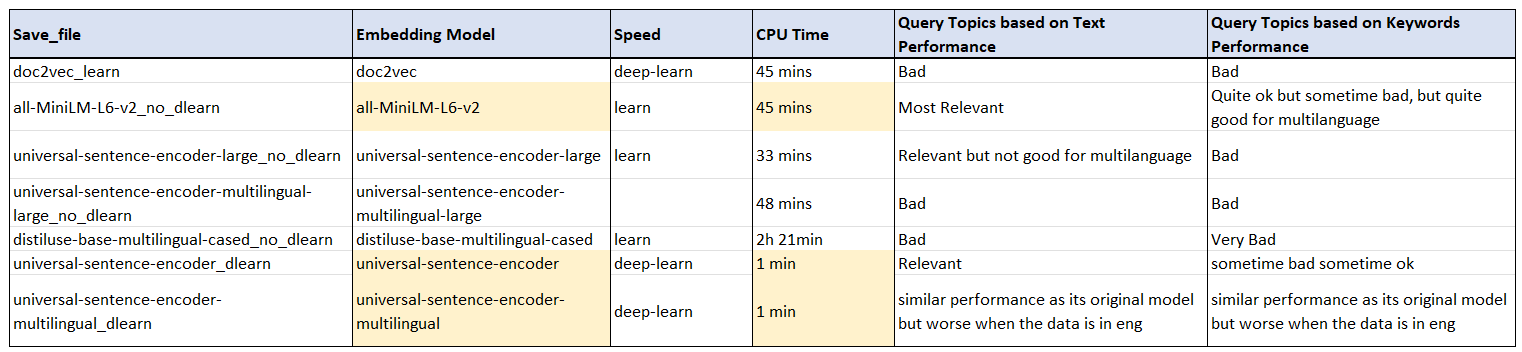

In [ ]:
%%time
# Example of creating and saving a top2vec model
np.random.seed(47)
model = Top2Vec(documents=list(esco_skill['skill_data']), embedding_model='doc2vec', ngram_vocab=True, use_embedding_model_tokenizer=True, speed='deep-learn')
model.save("doc2vec_learn")

2022-05-10 21:25:28,864 - top2vec - INFO - Pre-processing documents for training
2022-05-10 21:25:30,067 - top2vec - INFO - Creating joint document/word embedding


In [7]:
# Different embedding models
doc2vec_md = Top2Vec.load("Models/doc2vec_learn")
dbm_md = Top2Vec.load("Models/distiluse-base-multilingual-cased_no_dlearn")
usel_md = Top2Vec.load("Models/universal-sentence-encoder-large_no_dlearn")
useml_md = Top2Vec.load("Models/universal-sentence-encoder-multilingual-large_no_dlearn")
usem_md = Top2Vec.load("Models/universal-sentence-encoder-multilingual_dlearn")
use_md = Top2Vec.load("Models/universal-sentence-encoder_dlearn")
amlm_md = Top2Vec.load("Models/all-MiniLM-L6-v2_no_dlearn")

#### Observation:
- In the end, **'universal-sentence-encoder'** is selected as the embedding model for top2vec given its fastest speed and its higher relevancy when querying ESCO topic based on GO1 Course full text. 'universal-sentence-encoder-multilingual' is not selected in this case, because even though it works better especially for languages other than English, but its relevancy become worse when the language is in English. Since 92% of the GO1 courses is in English, so 'universal-sentence-encoder' would be a better fit in this case. In fact, for those courses which are in other languages, they still contain English tags / topics which would still useful for the topic modelling even using 'universal-sentence-encoder'

## Experiments Playground

### 1. Extract model info

In [8]:
def extract_model_info(model):
    total_topics = model.get_num_topics()
    total_vocab = len(model.vocab)
    topic_sizes, topic_nums = model.get_topic_sizes()
    topic_words, word_scores, topic_nums = model.get_topics()
    model_info = pd.DataFrame({'Topic Index':topic_nums, 'No. of Doc': topic_sizes, 'Topic Words': [x for x in topic_words], 'Word Scores': [x for x in word_scores]})
    return total_topics, total_vocab, model_info

In [9]:
extract_model_info(use_md)[:2]

(226, 8598)

In [10]:
extract_model_info(use_md)[2]

Topic Index  No. of Doc  \
0              0         165   
1              1         162   
2              2         160   
3              3         154   
4              4         147   
..           ...         ...   
221          221          24   
222          222          23   
223          223          22   
224          224          22   
225          225          21   

                                           Topic Words  \
0    [customer complaints, customer requests, custo...   
1    [geothermal energy, geothermal power, energy e...   
2    [ship, maritime navigation, vessel, vessel man...   
3    [geological explorations, geological mapping, ...   
4    [regarding animal, hospitalised animals, anima...   
..                                                 ...   
221  [dairy processing, dairy products, dairy, dair...   
222  [fishing maneuvres, fishery, fishing, fishing ...   
223  [fruits, fruit picking, fruit, vegetables, veg...   
224  [intraocular lenses, lenses, corrective lenses...   
225  [grapes grape, vine raisin, raisin grapes, gra...   

                                           Word Scores  
0    [0.53382134, 0.5195166, 0.51491594, 0.51471233...  
1    [0.46245202, 0.40630627, 0.37561762, 0.3684736...  
2    [0.46923566, 0.46562475, 0.46310782, 0.4474099...  
3    [0.43769097, 0.4272405, 0.3992591, 0.39041263,...  
4    [0.5290744, 0.4870443, 0.48630482, 0.47854382,...  
..                                                 ...  
221  [0.5604208, 0.5506331, 0.54780585, 0.50362605,...  
222  [0.5934247, 0.5721815, 0.5717725, 0.5471628, 0...  
223  [0.45493656, 0.44614428, 0.44582778, 0.4375543...  
224  [0.6400341, 0.61542094, 0.61118406, 0.588557, ...  
225  [0.5781731, 0.538204, 0.5269098, 0.51520157, 0...  

[226 rows x 4 columns]

### 2. Find GO1 courses based on its specific topic

#### Observation:
- Experimented different topics with indices such as 1162,1163,500,80000,38,1,0
- Found that use_md worked best in term of relevancy and speed

In [69]:
# Find courses under specific topic:
def course_search_based_on_topic(topic):
    ind_list = []
    for row in range(len(df['topics_list'])):
        if topic in df['topics_list'][row]:
            ind_list.append(row)
    return df.iloc[ind_list]

In [70]:
course_search_based_on_topic('python').index

Int64Index([ 1076,  1162,  1163,  1322,  1346,  1434,  1435,  1436,  1438,
             2048,
            ...
            78244, 78289, 78305, 78365, 78369, 78373, 78374, 78597, 78732,
            78793],
           dtype='int64', length=785)

In [89]:
index = 1163
print('title: ', df['title'][index])
print('tags: ', df['tags'][index])
print('topics: ', df['topics'][index])
print('description: ', df['description'][index])

title:  A Note on Using Financial Data in Python
tags:  it skills, python, finance, business skills
topics:  technology skills, programming and web development, python
description:    Course Overview   Do you want to learn how to use Python in a working environment? Are you a young professional interested in a career in Data Science? Would you like to explore how Python can be applied in the world of Finance and solve portfolio optimization problems? If so, then this is the right course for you!    Target Audience    Aspiring data scientists   Programming beginners  People interested in finance and investments   Programmers who want to specialize in finance   Everyone who wants to learn how to code and apply their skills in practice   Finance graduates and professionals who need to better apply their knowledge in Python    This video is part of the course  Python for Finance  Investment Fundamentals and Data Analytics  


### 3. Query ESCO Topics based on GO1 Course Data

In [90]:
query = df['course_data'][index]
query

'A Note on Using Financial Data in Python technology skills, programming and web development, python it skills, python, finance, business skills   Course Overview   Do you want to learn how to use Python in a working environment? Are you a young professional interested in a career in Data Science? Would you like to explore how Python can be applied in the world of Finance and solve portfolio optimization problems? If so, then this is the right course for you!    Target Audience    Aspiring data scientists   Programming beginners  People interested in finance and investments   Programmers who want to specialize in finance   Everyone who wants to learn how to code and apply their skills in practice   Finance graduates and professionals who need to better apply their knowledge in Python    This video is part of the course  Python for Finance  Investment Fundamentals and Data Analytics  '

0.45039332
0.38513723
0.3768153
0.36464238
0.3319299


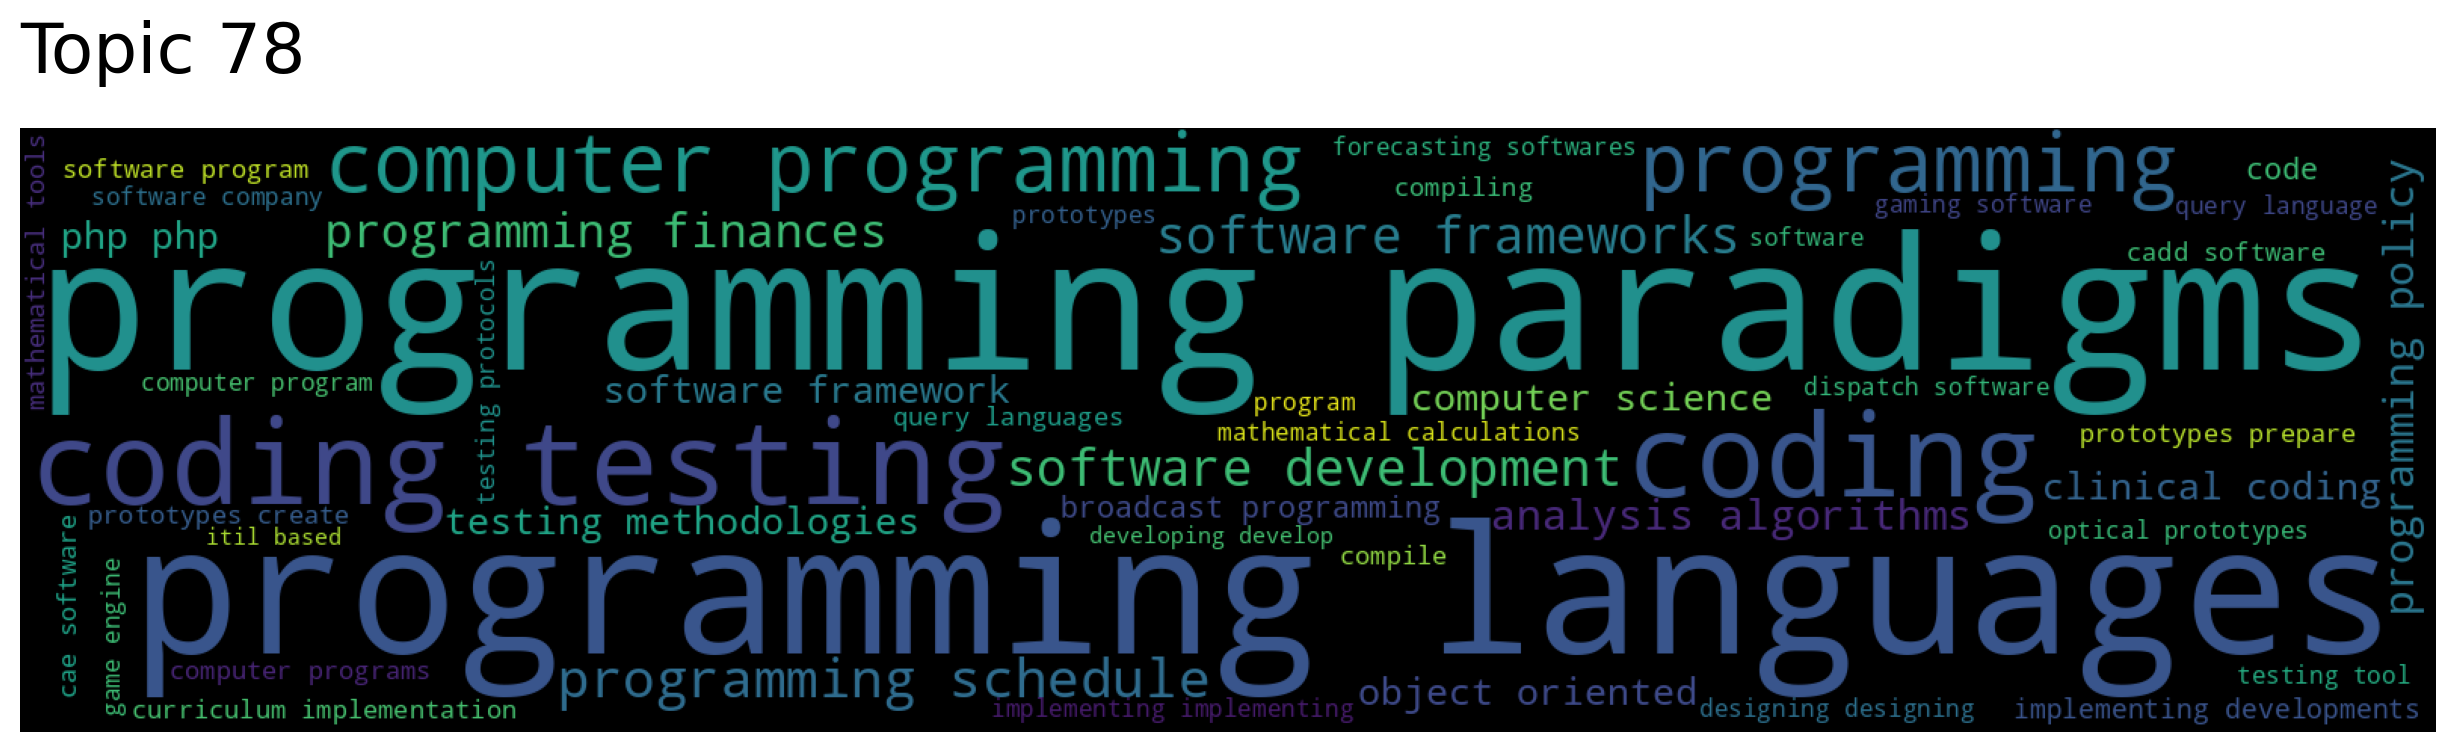

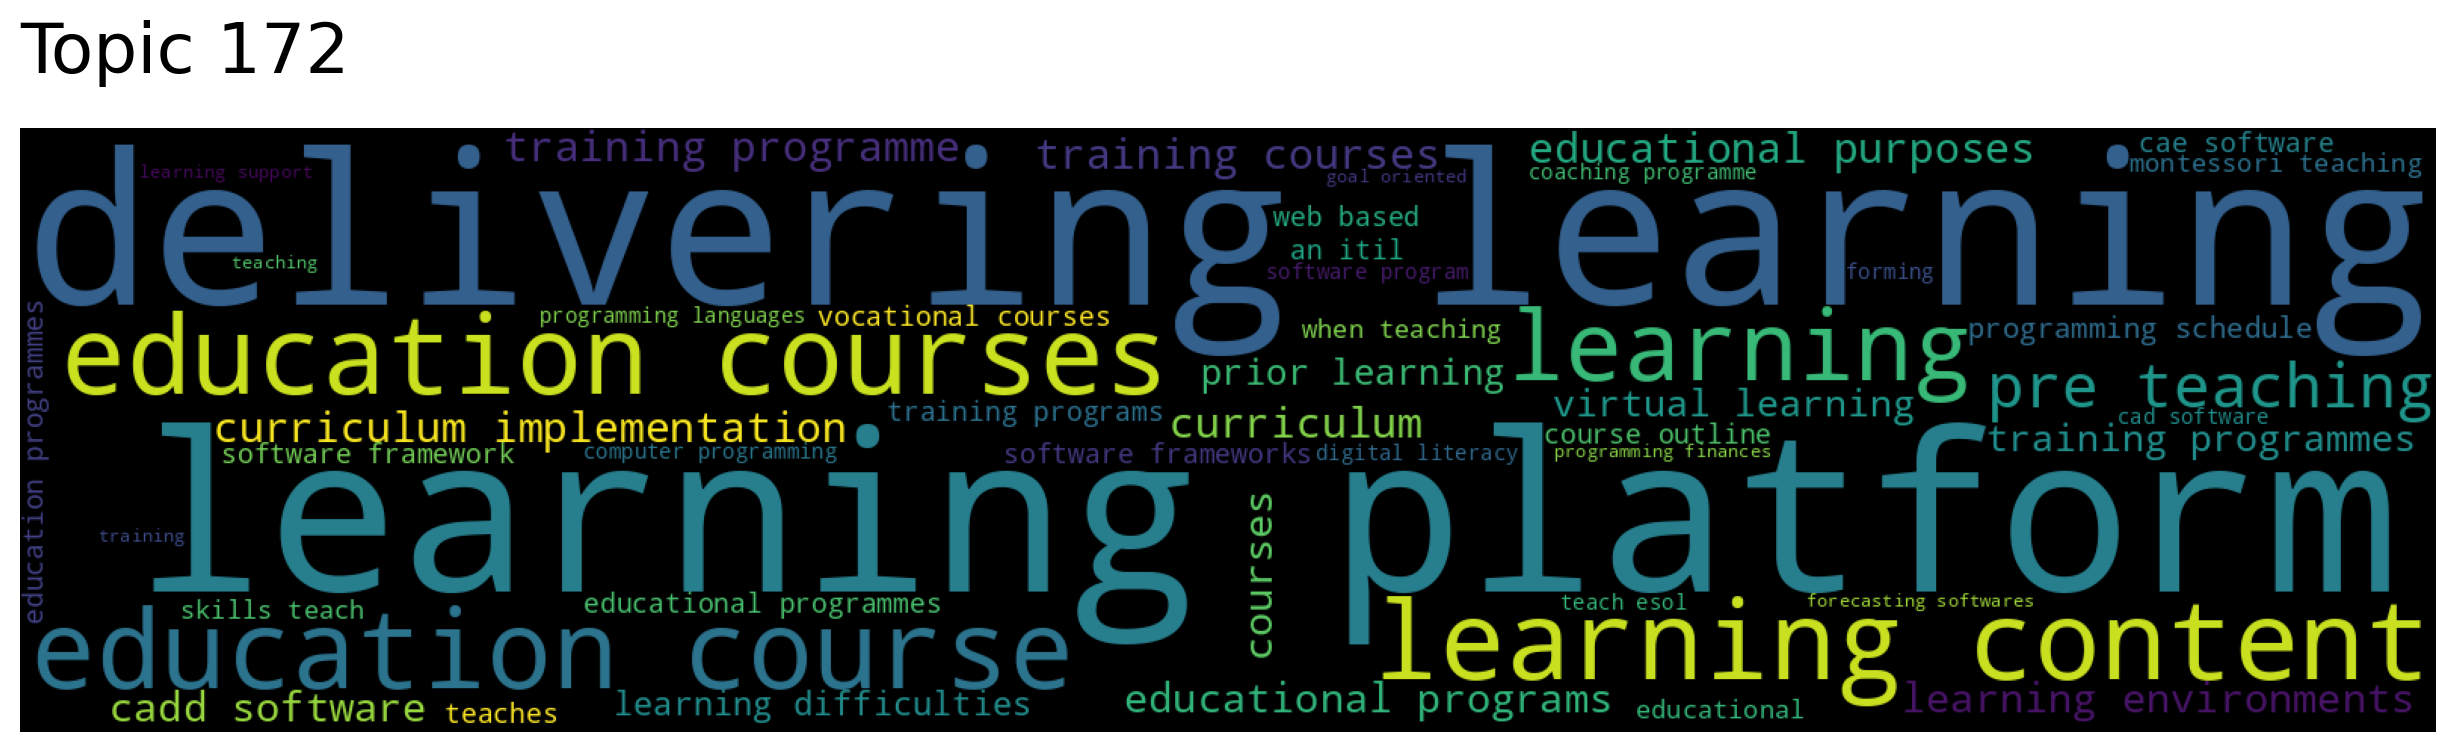

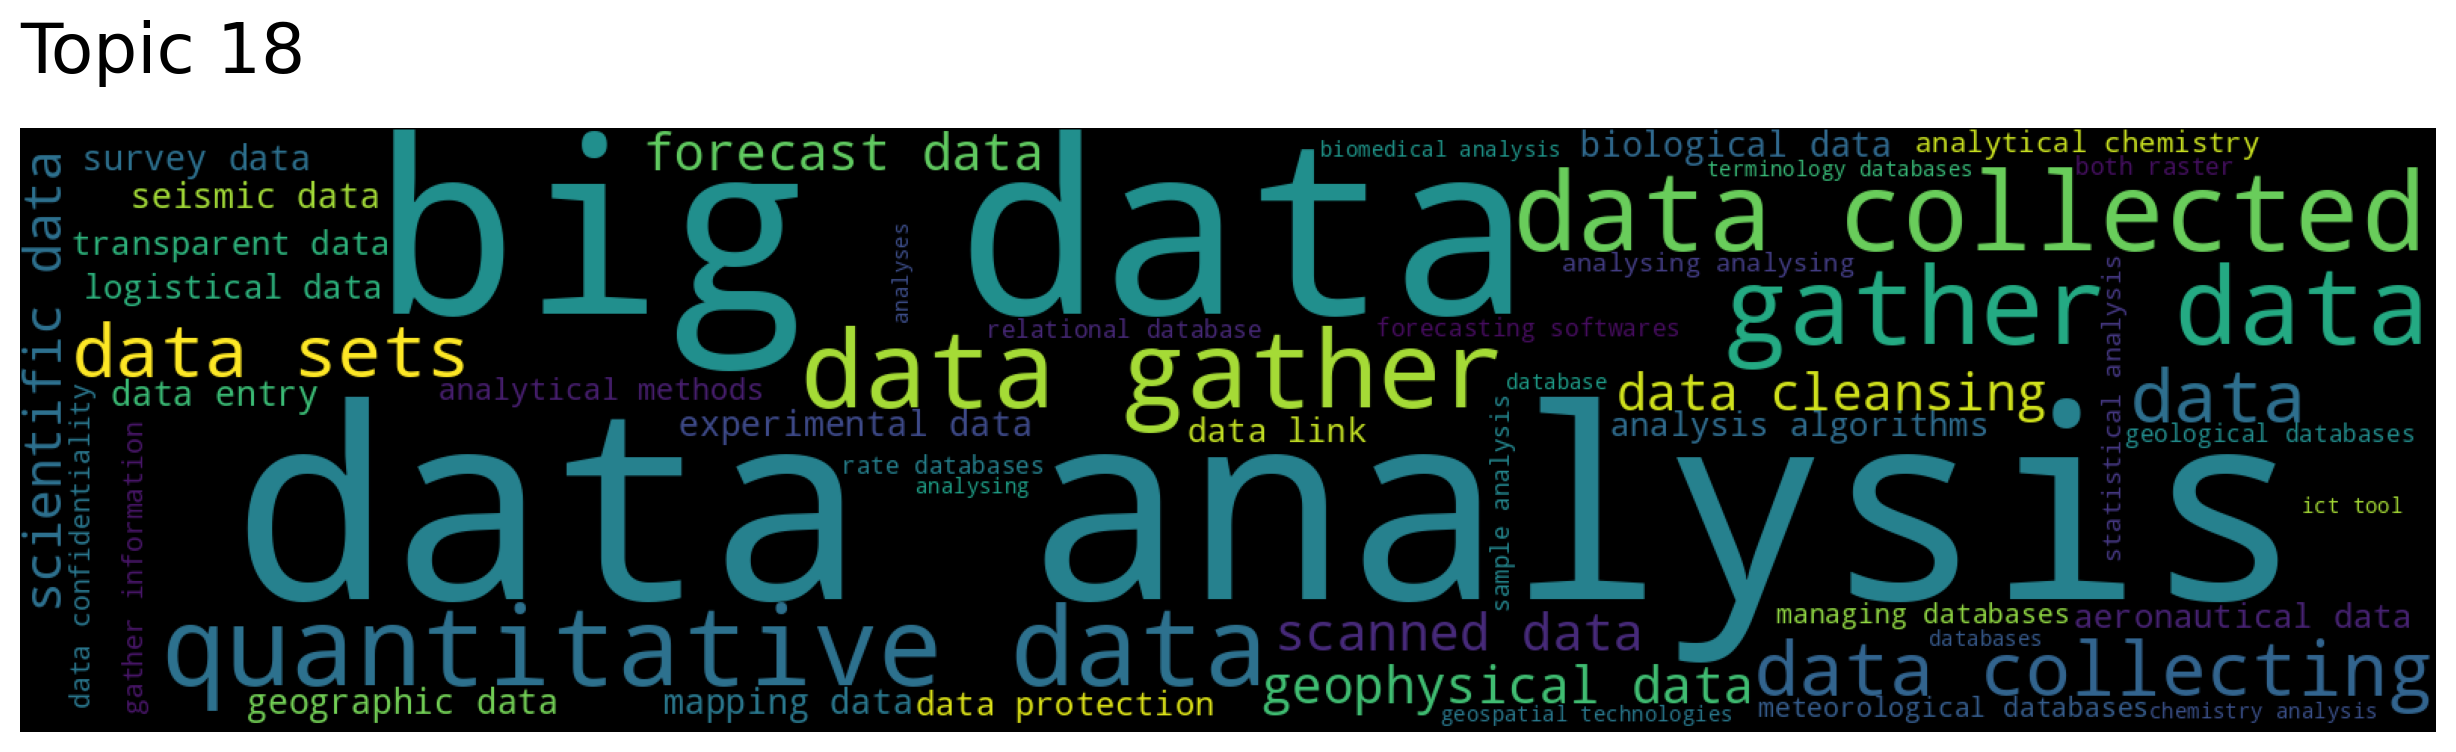

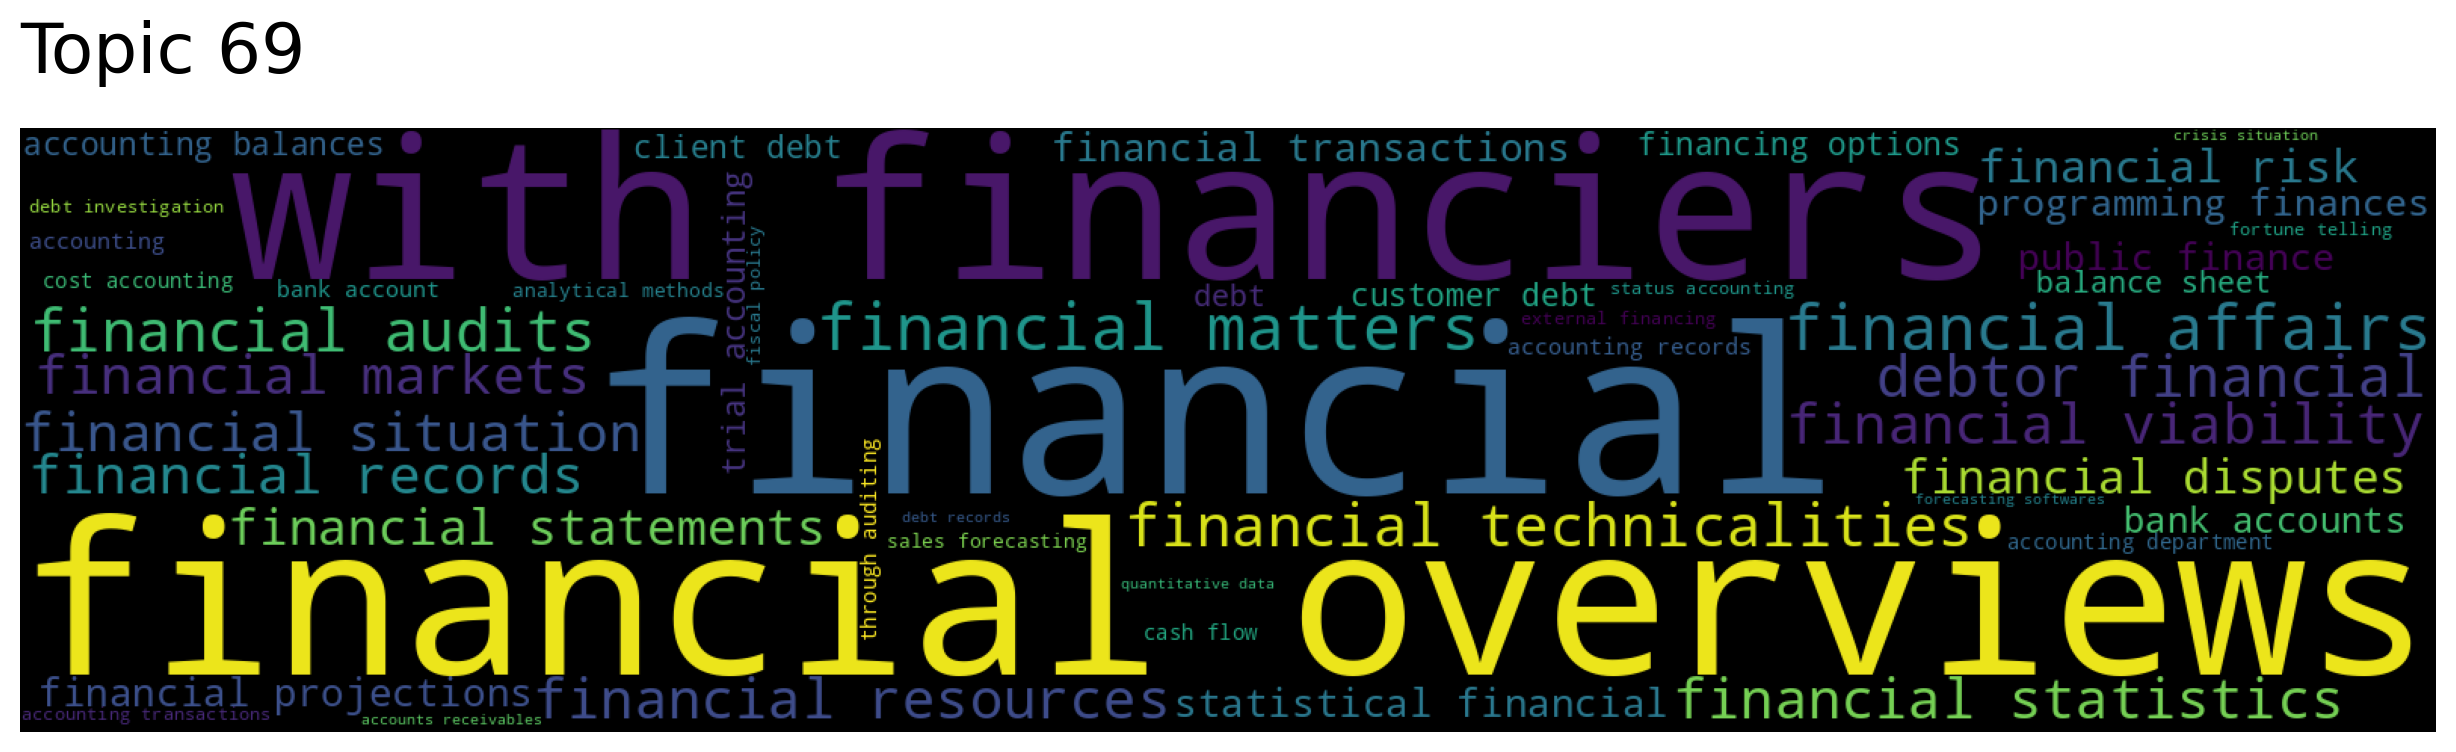

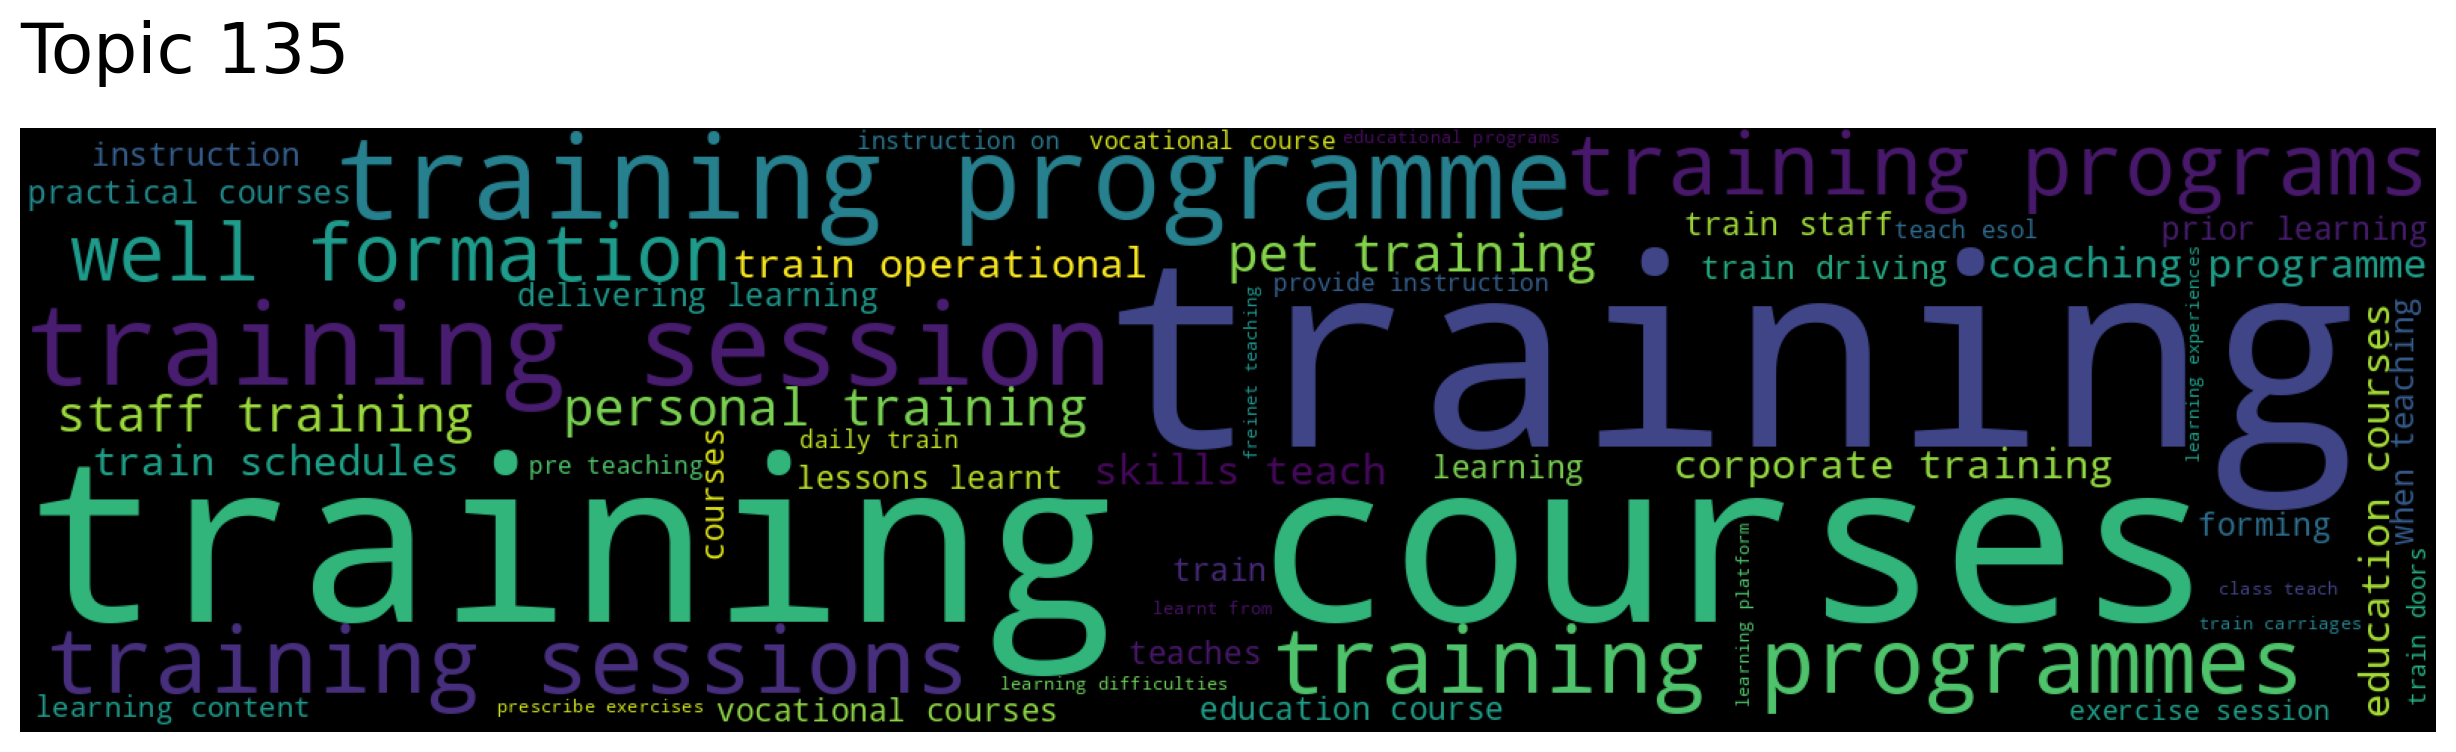

In [91]:
model = use_md
topic_words, word_scores, topic_scores, topic_nums = model.query_topics(query, num_topics=5, reduced=False, tokenizer=None)

for r in range(len(topic_nums)):
    print(topic_scores[r])
    model.generate_topic_wordcloud(topic_nums[r])

### 4. Query ESCO Topics based on GO1 Course Data's Keywords which appeared in Model Vocab

In [92]:
import spacy
from spacy.matcher import PhraseMatcher
nlp = spacy.load("en_core_web_sm")

matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
terms = list(model.vocab)

# Only run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("TerminologyList_Skill", patterns)

doc = nlp(df['course_data'][index])
matches = matcher(doc)

keywords_match = []
for match_id, start, end in matches:
    span = doc[start:end]
    keywords_match.append(span.text)

In [93]:
str(keywords_match)

"['on', 'Using', 'Financial', 'Data', 'in', 'technology', 'skills', 'programming', 'and', 'web', 'development', 'it', 'skills', 'business', 'skills', 'Course', 'Do', 'to', 'how', 'to', 'use', 'in', 'working', 'working environment', 'environment', 'Are', 'young', 'professional', 'in', 'career', 'in', 'Data', 'Science', 'like', 'to', 'how', 'can', 'can be', 'be', 'be applied', 'applied', 'in', 'the', 'of', 'and', 'solve', 'problems', 'If', 'so', 'this', 'is', 'the', 'right', 'course', 'for', 'Target', 'Target Audience', 'Audience', 'data', 'Programming', 'People', 'in', 'and', 'who', 'to', 'in', 'who', 'to', 'how', 'to', 'code', 'and', 'apply', 'their', 'skills', 'in', 'practice', 'and', 'professionals', 'who', 'need', 'to', 'apply', 'their', 'knowledge', 'in', 'This', 'video', 'is', 'part', 'of', 'the', 'course', 'for', 'Investment', 'Fundamentals', 'and', 'Data']"

0.13997874527193438
0.13327412563956778
0.1295226142160825
0.12927557492240463
0.12843200612428635


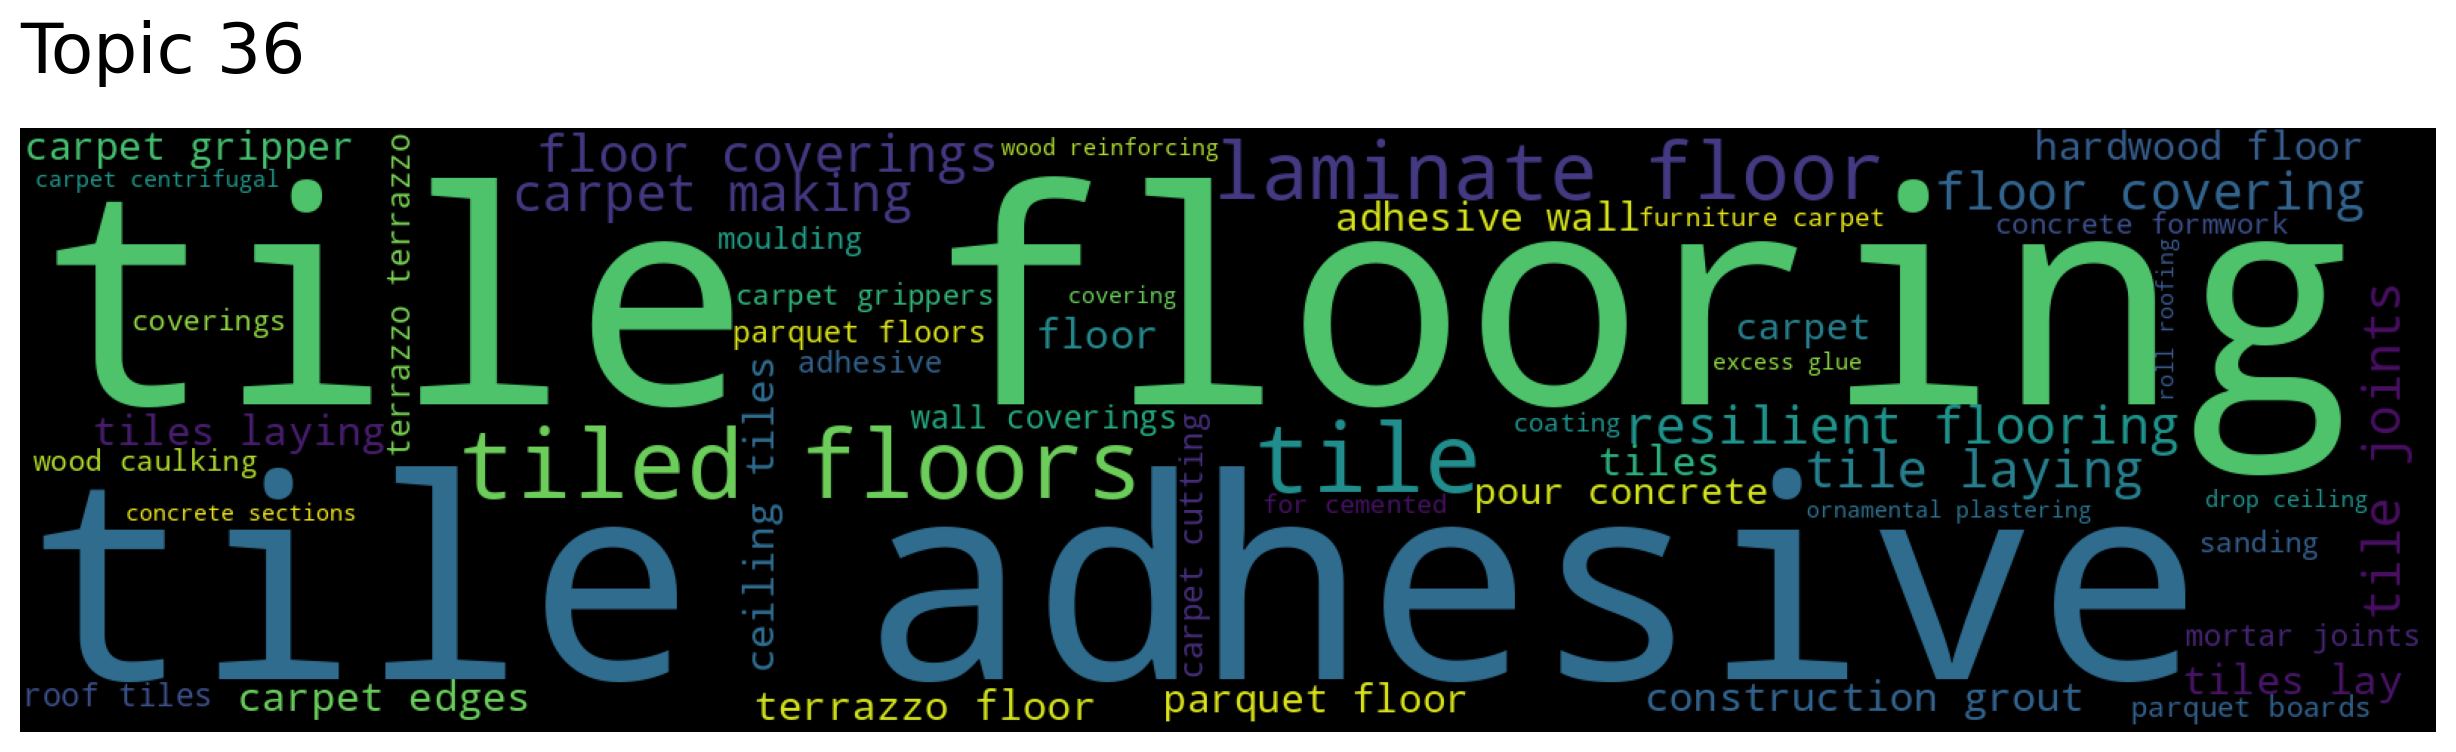

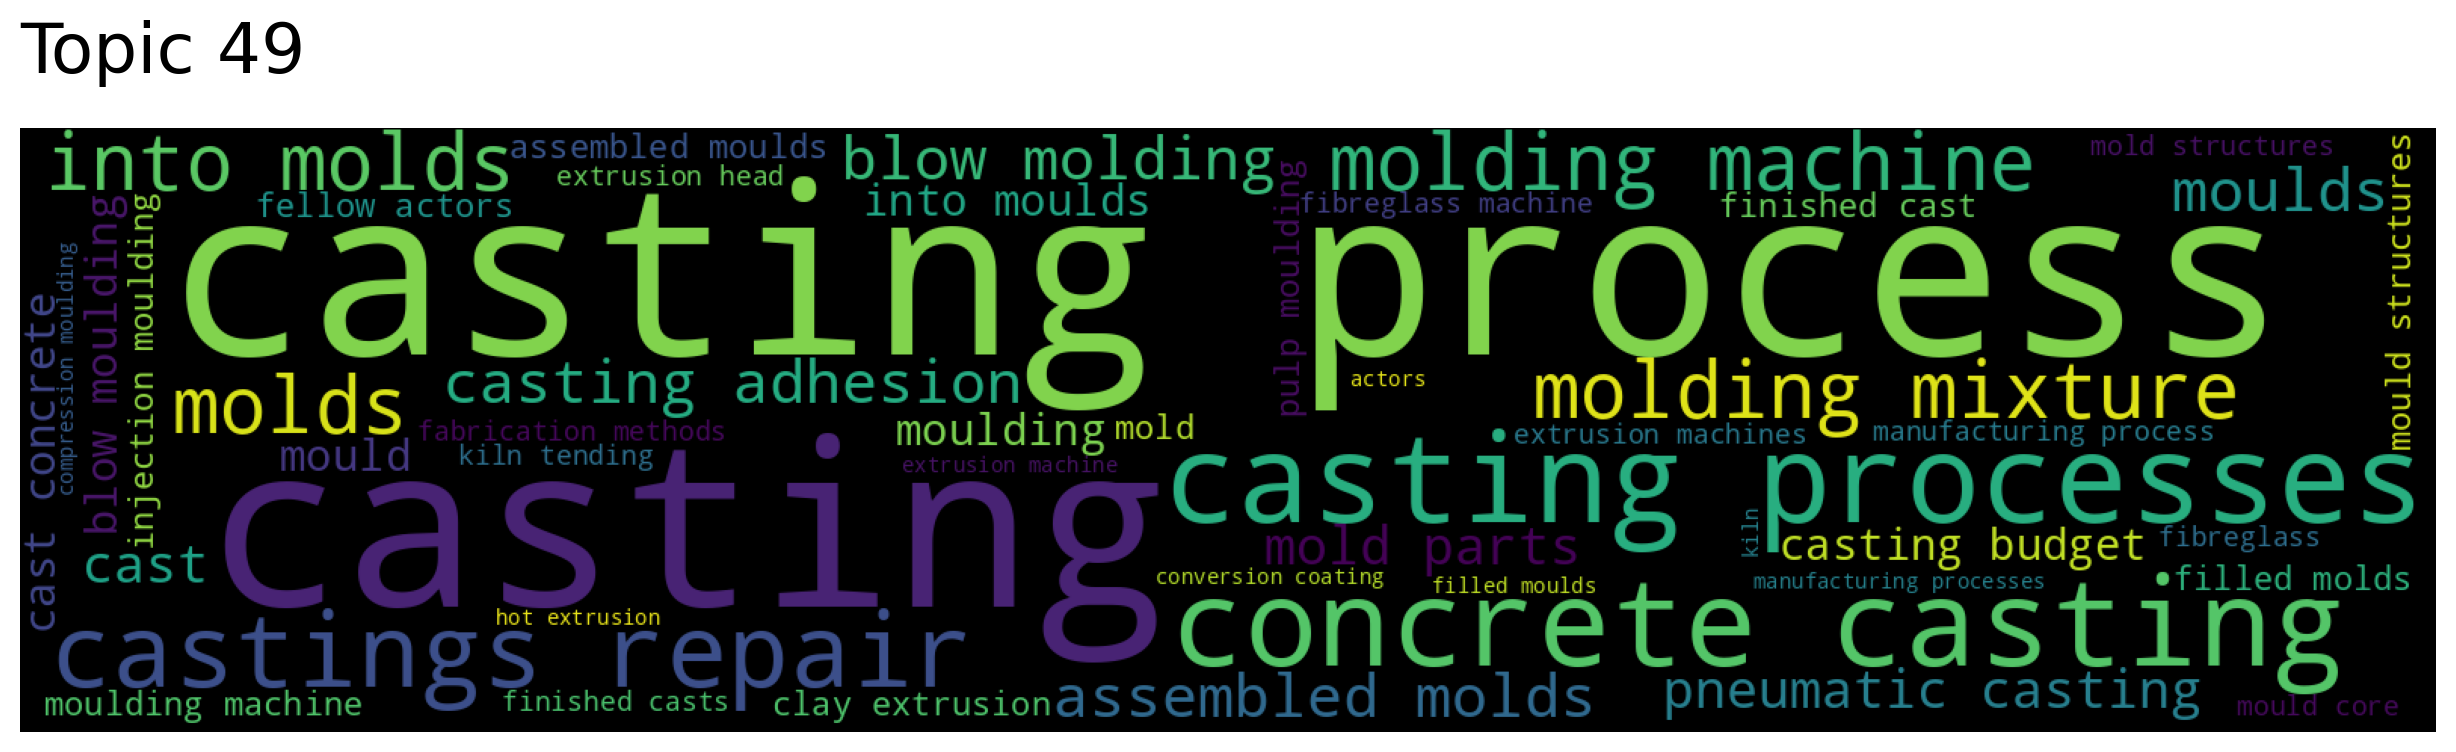

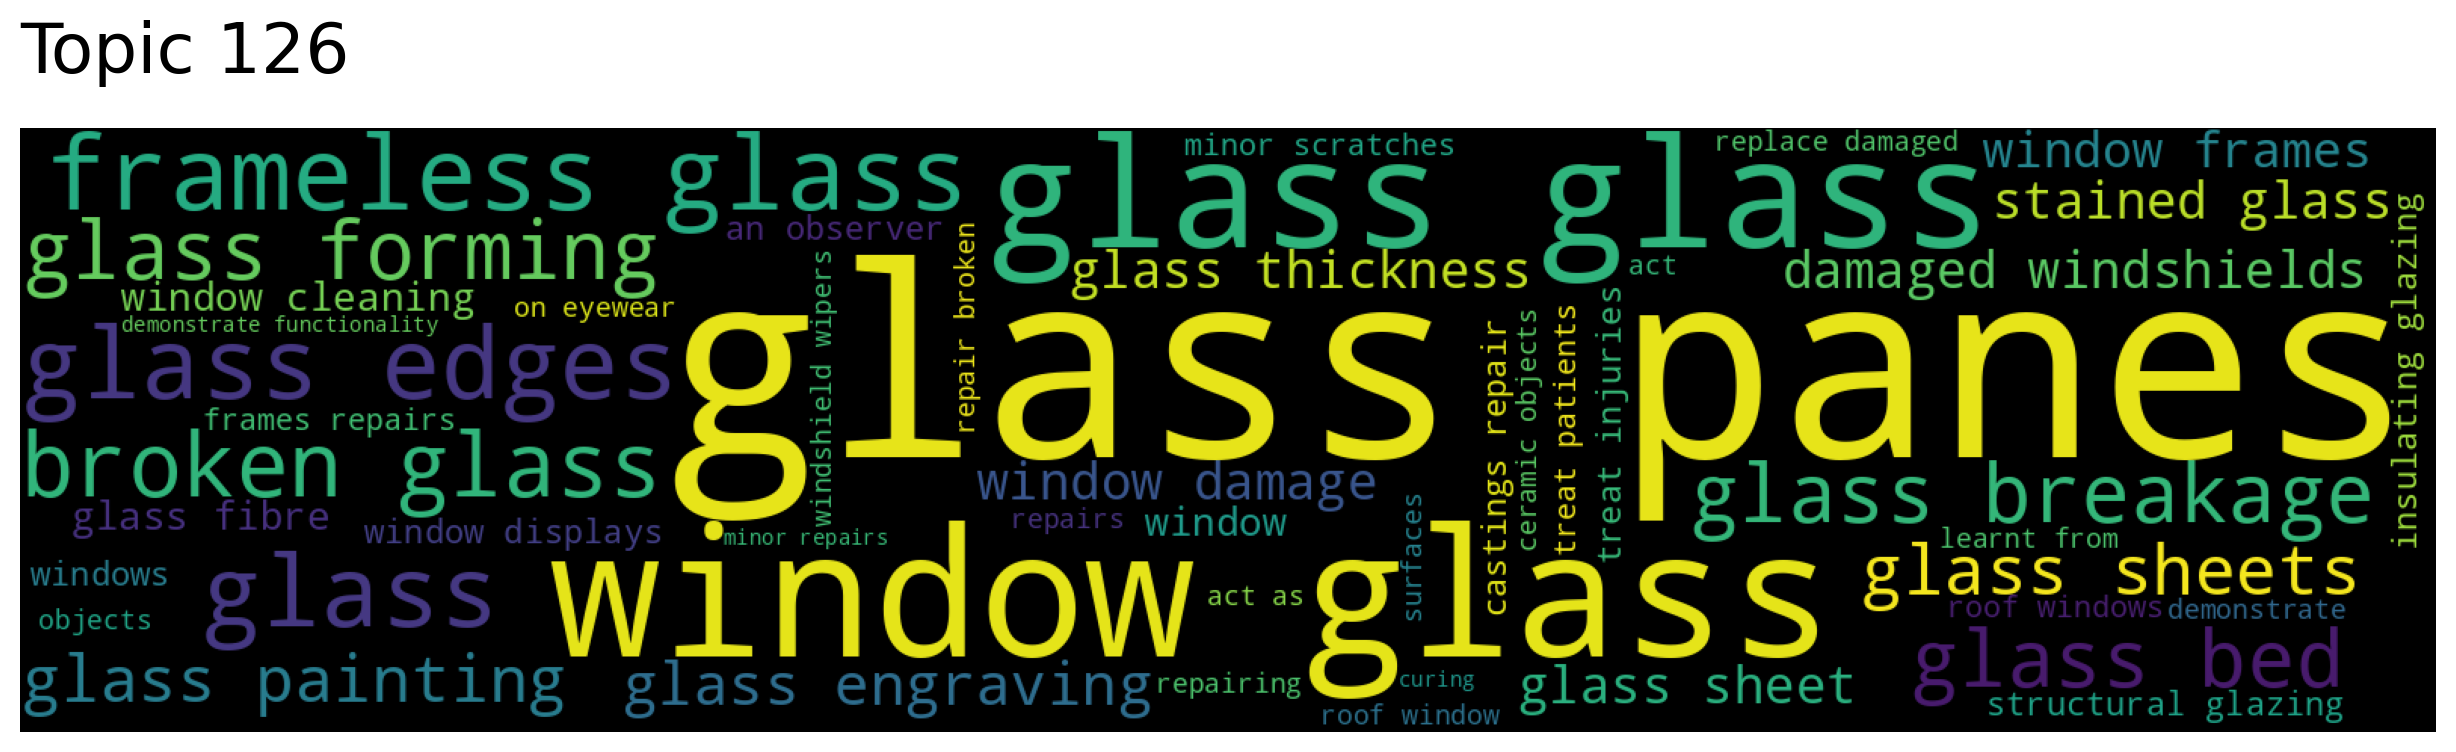

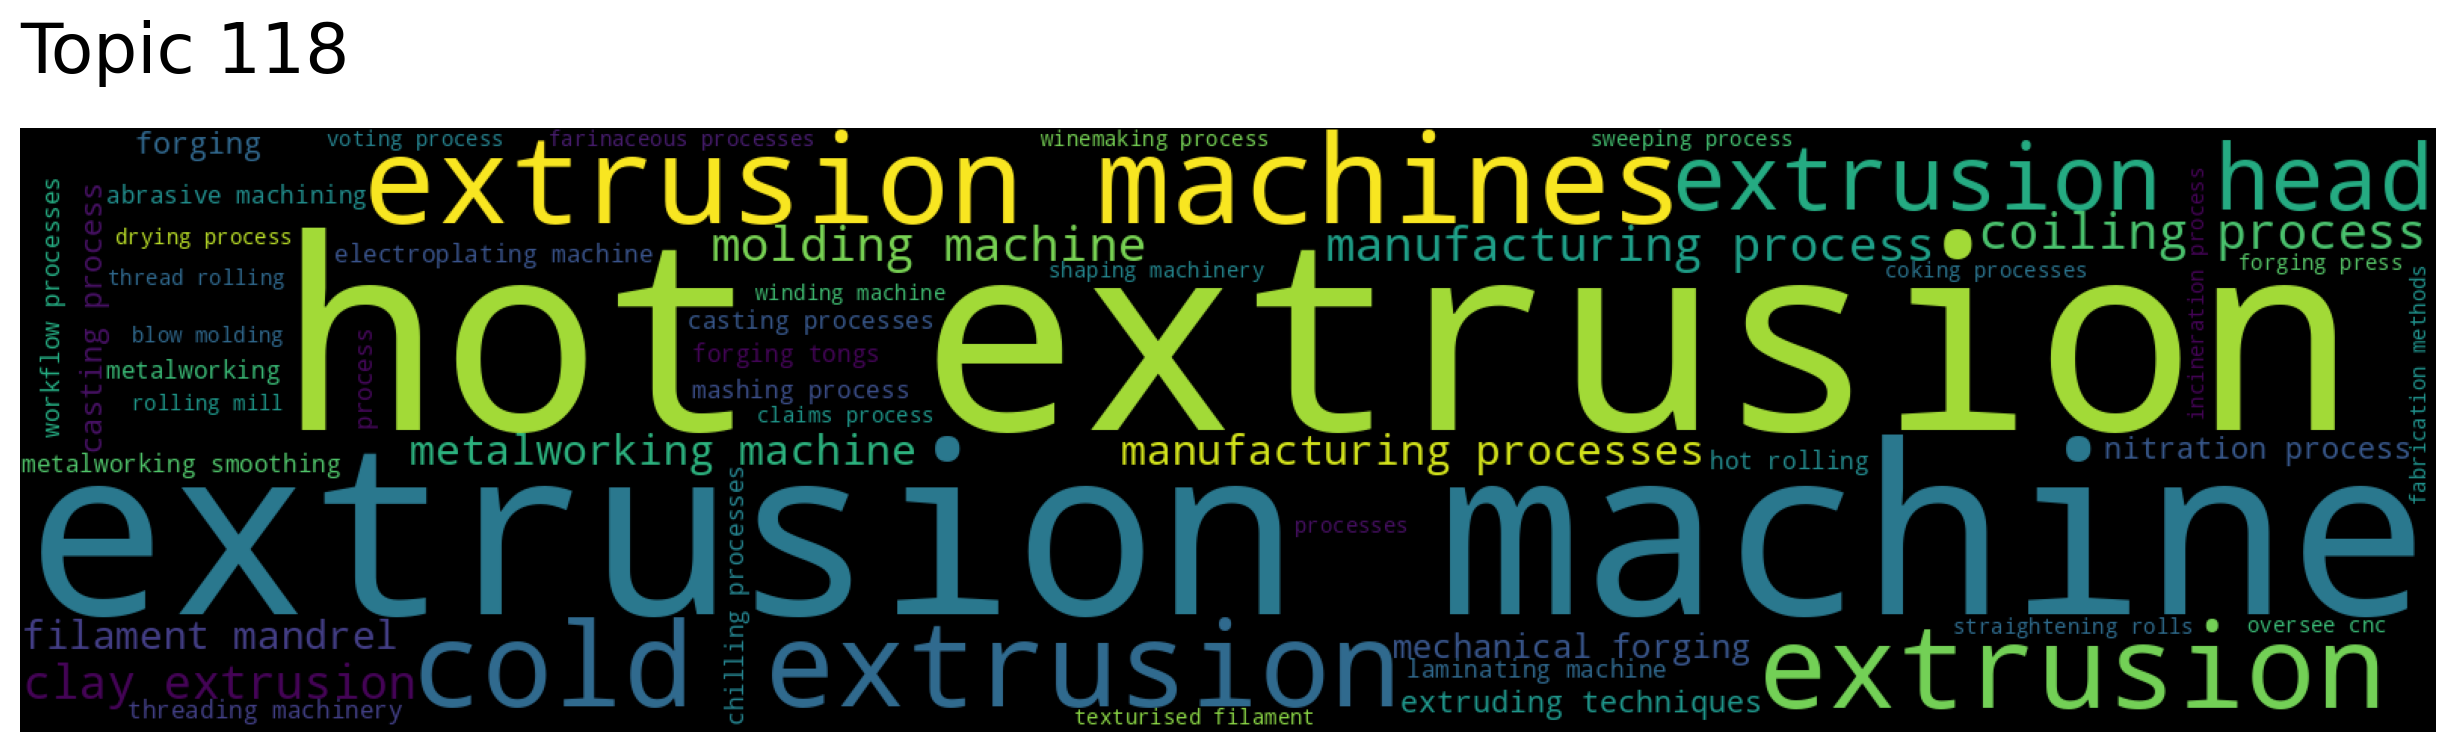

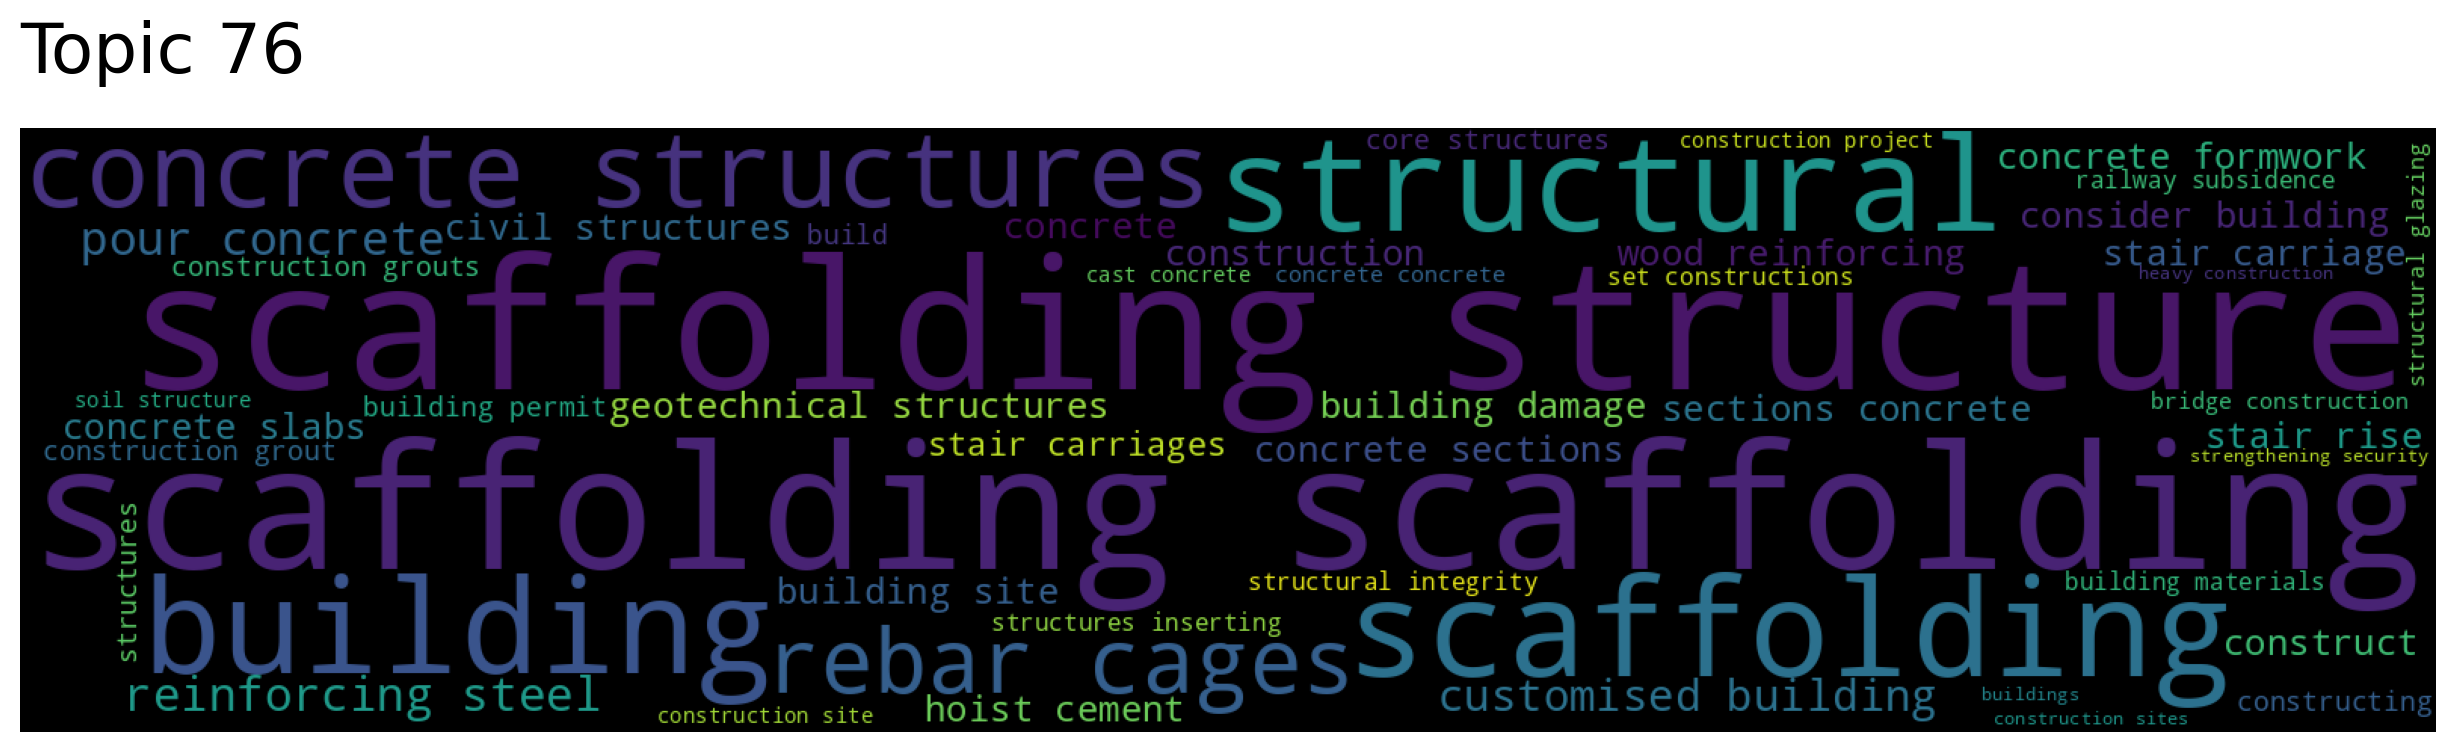

In [94]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=keywords_match, num_topics=5)

for r in range(len(topic_nums)):
    print(topic_scores[r])
    model.generate_topic_wordcloud(topic_nums[r])

### 5. Combine Search

In [95]:
_, _, topic_scores_qt, topic_nums_qt = model.query_topics(query, num_topics=5, reduced=False, tokenizer=None)
_, _, topic_scores_st, topic_nums_st = model.search_topics(keywords=keywords_match, num_topics=5)

In [96]:
cmb_search_df = pd.DataFrame({'Topic Number': list(topic_nums_qt) +  list(topic_nums_st), 'Topic Relevancy': list(topic_scores_qt) +  list(topic_scores_st)})
cmb_search_df = (cmb_search_df.sort_values(by='Topic Relevancy', ascending=False) \
                              .drop_duplicates(subset ="Topic Number"))
cmb_search_df

Topic Number  Topic Relevancy
0            78         0.450393
1           172         0.385137
2            18         0.376815
3            69         0.364642
4           135         0.331930
5            36         0.139979
6            49         0.133274
7           126         0.129523
8           118         0.129276
9            76         0.128432

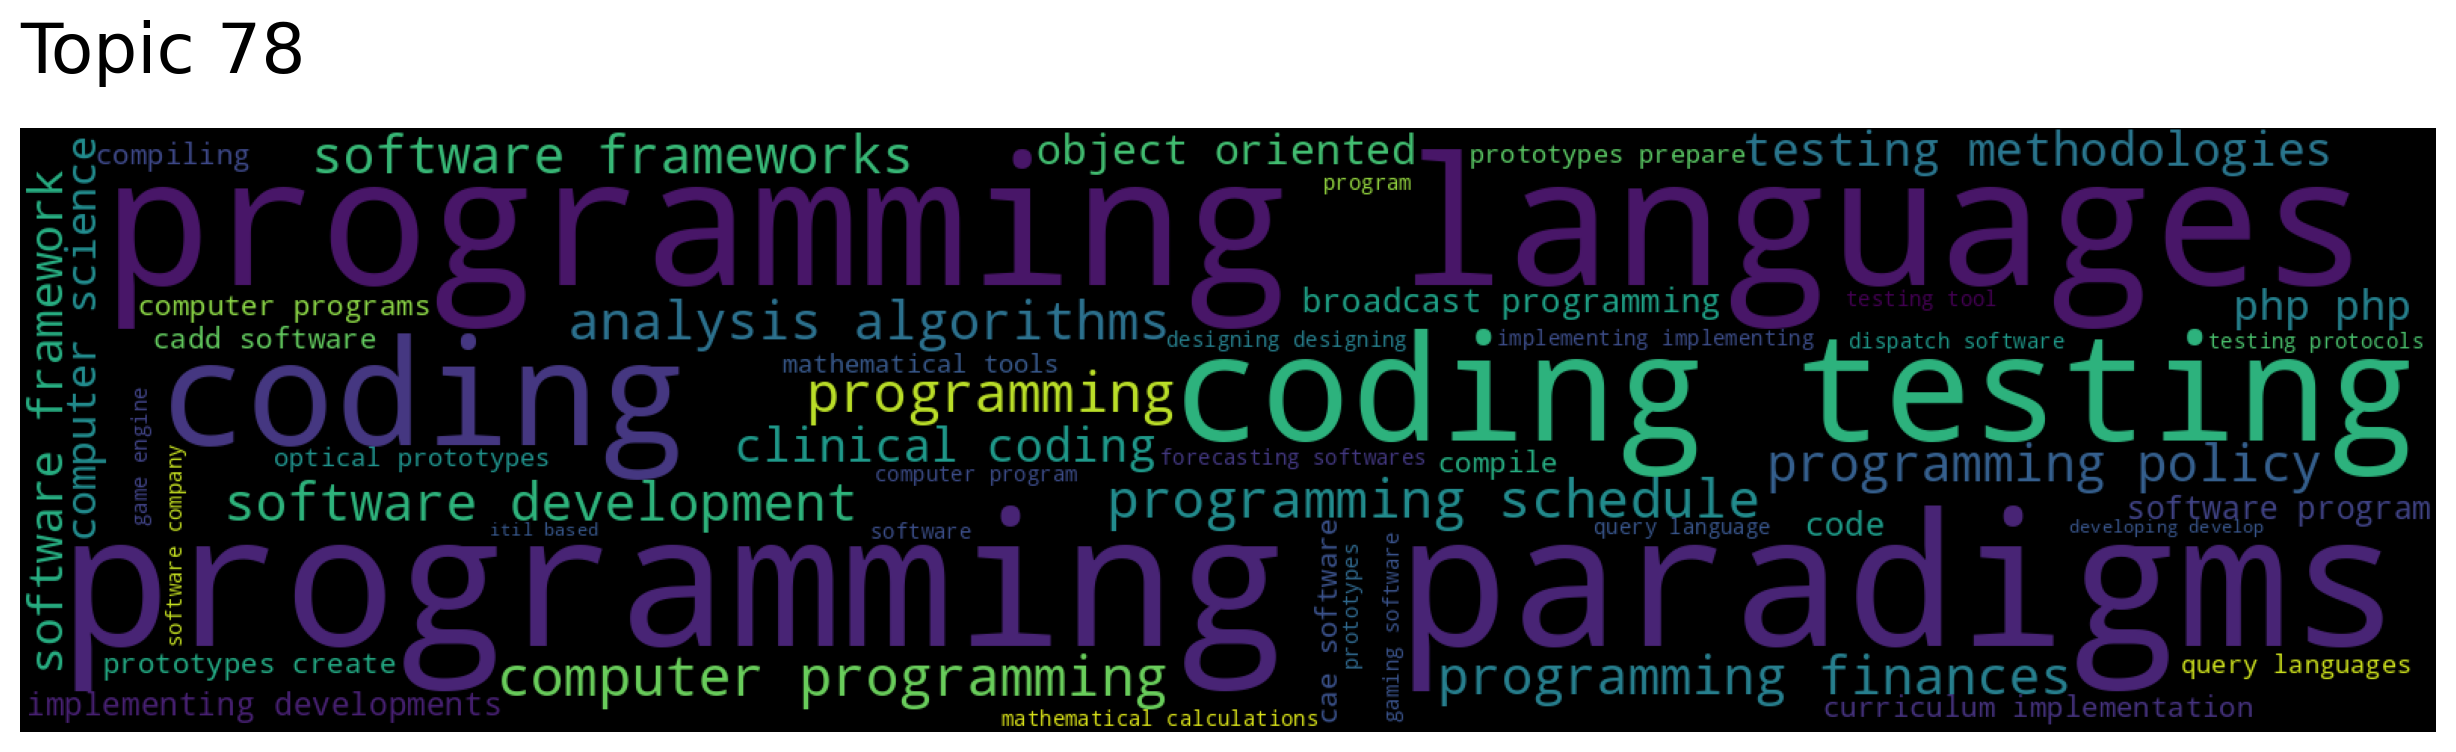

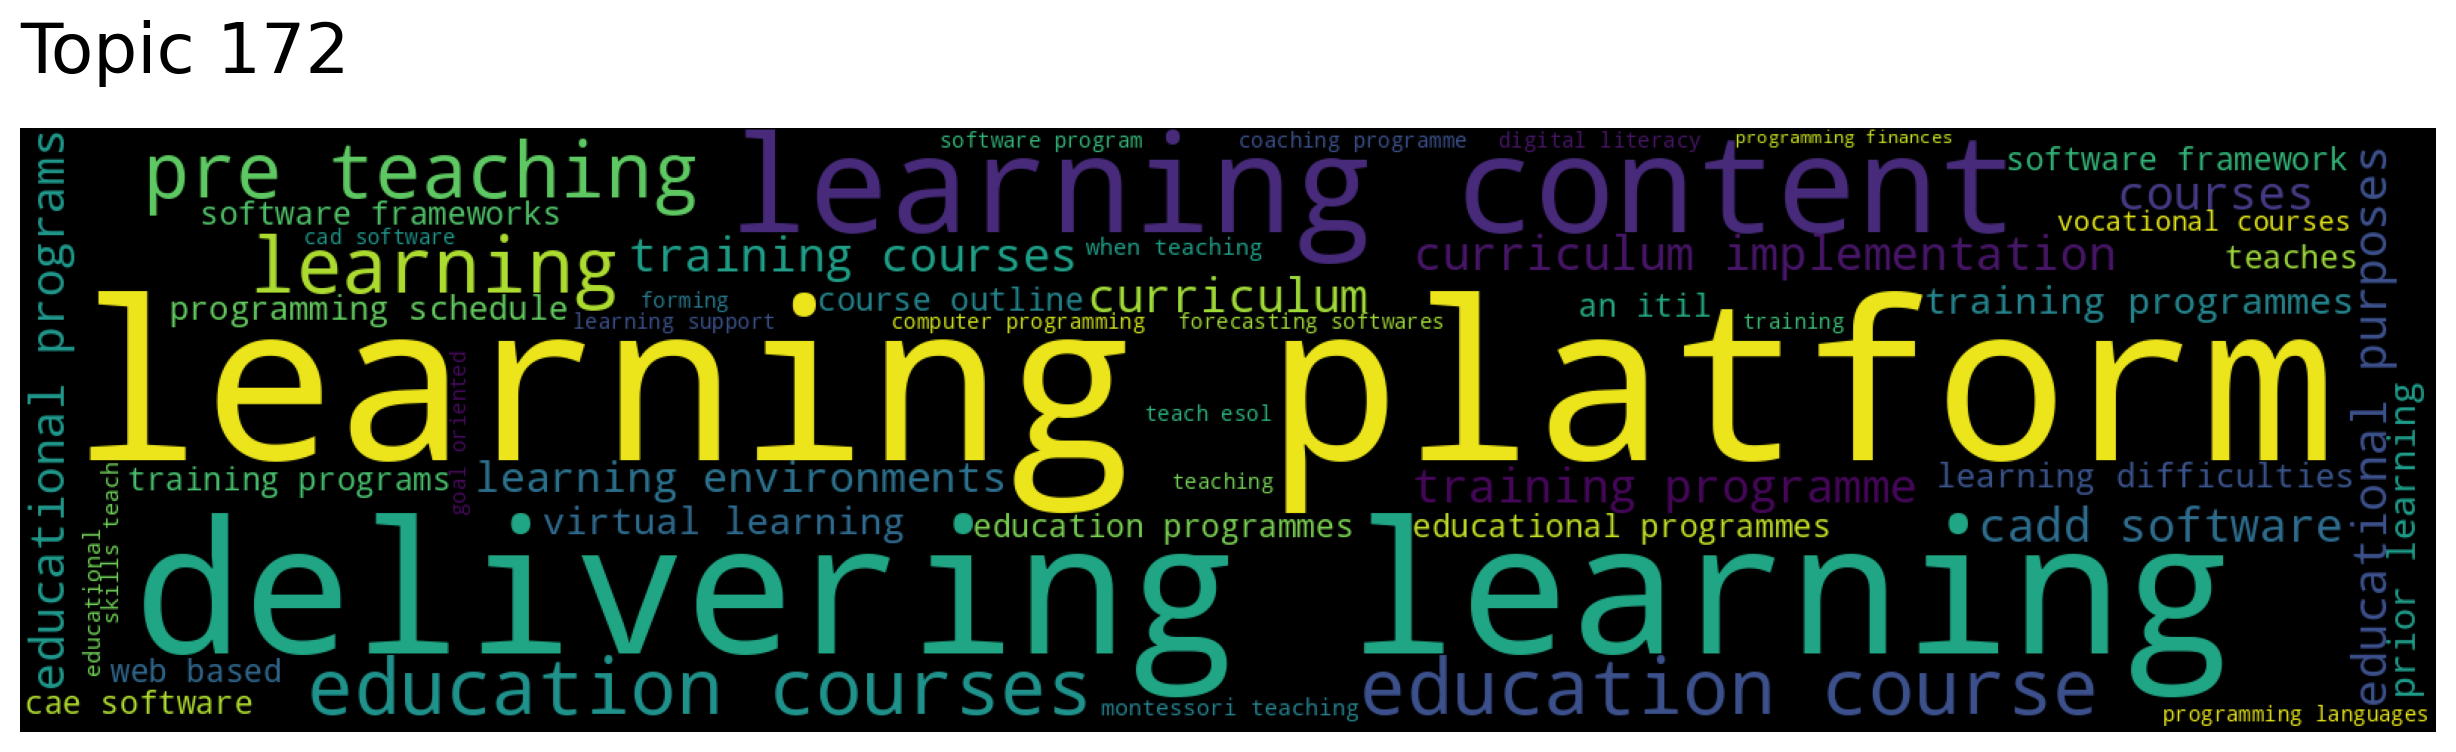

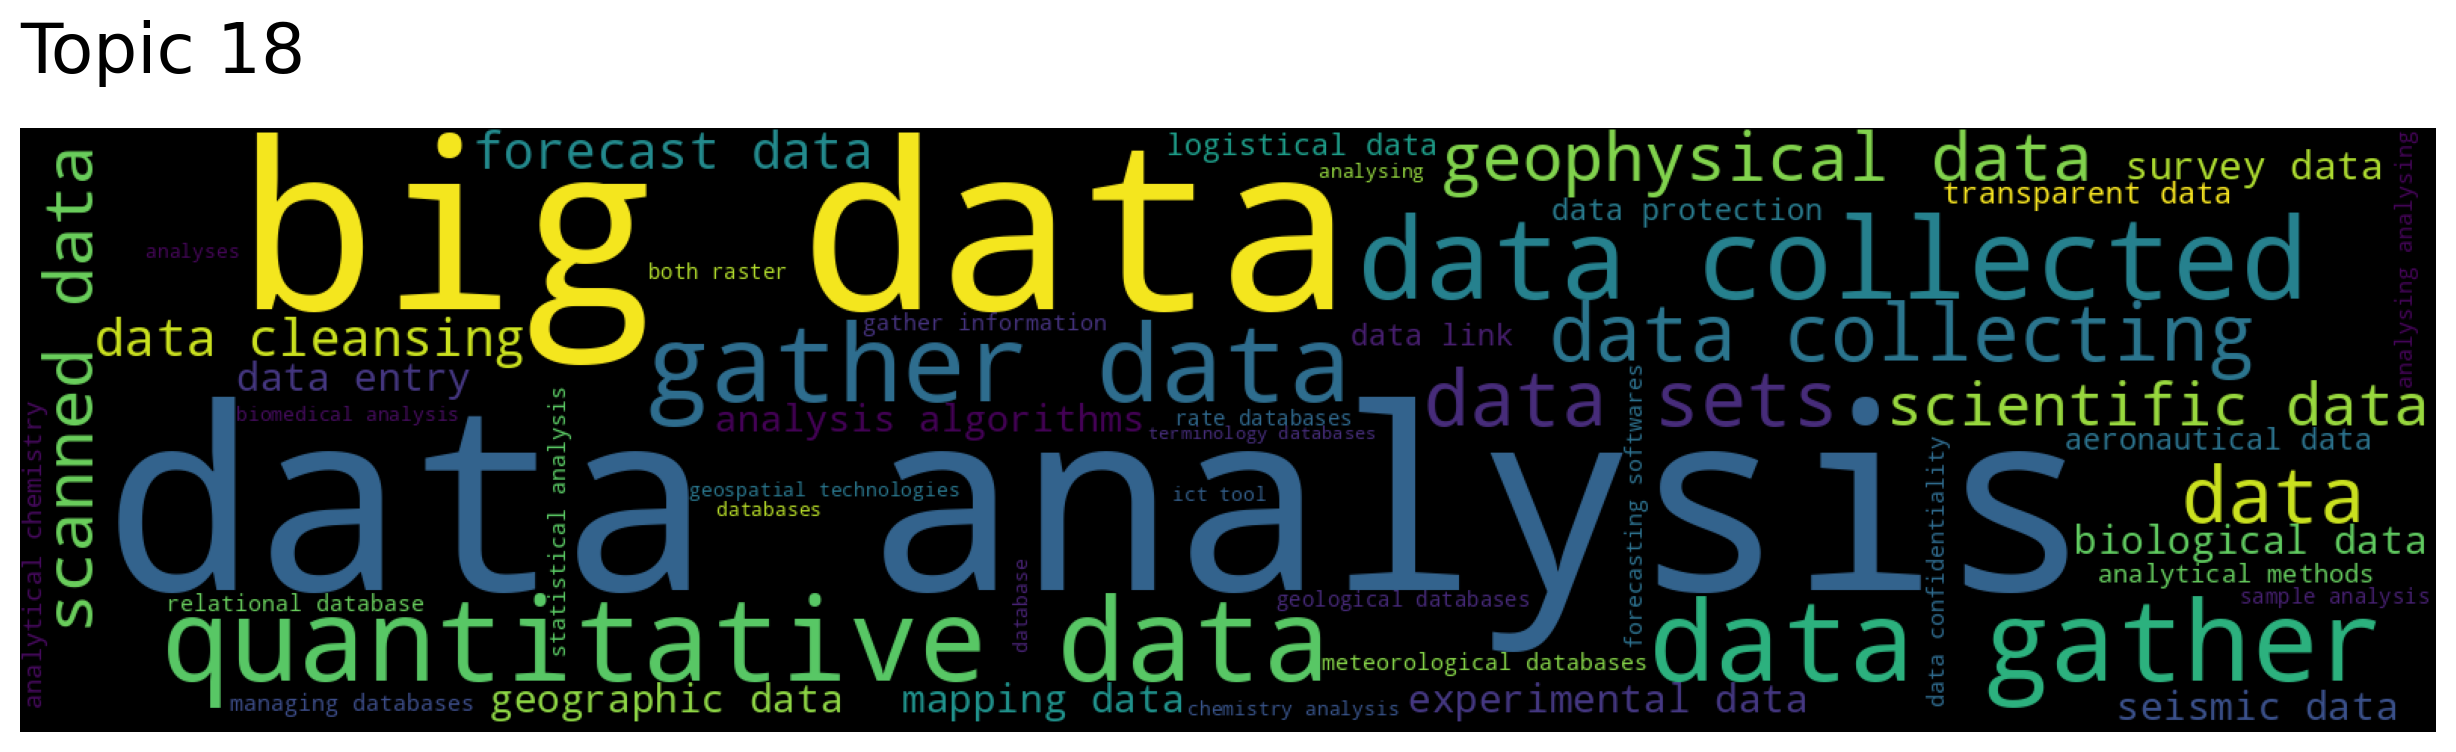

In [97]:
# Get the Top 3 Topics based on Combine Search
topic_nums_list = cmb_search_df['Topic Number'][:3]
for r in topic_nums_list:
    model.generate_topic_wordcloud(r)

In [98]:
model_info = extract_model_info(use_md)[2]
doc_ids = []
for elem in topic_nums_list:
    _, _, document_ids = model.search_documents_by_topic(topic_num = elem, num_docs = int(model_info[model_info['Topic Index']==elem]['No. of Doc'].values))
    doc_ids.append(document_ids)
doc_ids = [elem for array in doc_ids for elem in array]
len(doc_ids)

212

In [99]:
topic_nums_list = cmb_search_df['Topic Number'][:3]
topic_nums_list

0     78
1    172
2     18
Name: Topic Number, dtype: int64

#### Observation:
- Since **[Query ESCO Topics based on Course Data]** always work so much better than **[Query ESCO Topics based on Course Data's Keywords which appeared in the ESCO Model Vocab]**, so combination search does not give any value, just stick to first query method is enough

# Next Section: Think better way of building GO1 Course - ESCO Topic Relation

In [26]:
import spacy
from spacy.matcher import PhraseMatcher
nlp = spacy.load("en_core_web_sm")

model = use_md
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
terms = list(model.vocab)

# Only run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("TerminologyList_Skill", patterns)

In [27]:
# Check how many courses do not have keywords appeared in model vocab
%%time
Counter(['Not in model vocab' for text in df['course_data'] if not matcher(nlp(text))])

CPU times: user 20min 30s, sys: 0 ns, total: 20min 30s
Wall time: 20min 30s


Counter({'Not in model vocab': 7})

#### Observation:
- Only 7 GO1 courses do not have keywords appeared in ESCO Skill model vocab
- It took 20mins to check whether a GO1 course has any keyword appeared in model vocab
- So, it does not worth the time for this checking due to only 7 courses without keywords appeared in model vocab